# テーブルの作成

## 背景と目的

- パーツに不具合があった場合、3年以内であればワランティが適用され、無償で交換対応を行っている。
- ワランティ数が増えてきた場合には、費用を投じて鋳型を再作成し、不具合に対応することもあるが、その場合は鋳型の作成費用がかかる。
- 各モデル/各パーツの将来のワランティ数推移を予測し、鋳型を再作成すべきかどうかの意思決定を合理的に行い、利益の最大化を図りたい。

## 本プロジェクトの対象範囲(スコープ)

- 国内で生産された四輪/二輪車の一部のモデルの一部のパーツについて、1,3,6,12ヶ月後の月間ワランティ発生数を予測する。
    - 生産拠点コードが100100であるものを"国内で生産された"ものとする。
- モデル区分がAであるものを二輪, Bであるものを四輪とする。
- ワランティのFAILURE_DATEを故障日とし、"ワランティ発生時点"とする。ある月のうちに発生したワランティの総数を"月間ワランティ発生数"とする。
- 対象とするモデル及びパーツについては、以下の通り。
    - テラデータ(主担当: 眞田)が着手し、解説するもの
        - **四輪のパーツ-モデル組み合わせ上位100件**
    - スズキ様(主担当: 平岡様)が着手し、テラデータ(主担当: 眞田)が補助するもの
        - **二輪のパーツ-モデル組み合わせ上位100件**

- 目的(鋳型を再作成すべきか否かと意思決定)を達成するには、今回のスコープである将来のワランティ発生数推移の他に、1.各ワランティの対応費用及び2.鋳型の作成費用、3.新しい鋳型で作成されたパーツの将来のワランティ発生数推移を知る必要がある。これらについては本プロジェクトの**対象範囲外**とする。(9月末までに時間が余ったら着手)
    - もしこれらについても分析を行うとすれば、以下のようなアプローチが考えられる
        - 1.ワランティ対応費用
            - <font color='green'>簡単</font>: 単に過去平均を取る
            - <font color='blue'>普通</font>: 似たパーツ、似たモデルについては似たようなコストがかかる / 初回発生から回数や時間を経たものについては費用が下がる という仮定を置いて、費用についての回帰モデルを作成する
        - 2.鋳型の作成費用
            - <font color='green'>簡単</font>: 鋳型作成担当者に聞く
            - <font color='green'>簡単</font>: 過去の鋳型作成費用の平均を取る
            - <font color='blue'>普通</font>: 似たパーツ、似たモデルについては似たようなコストがかかるという仮定を置いて、費用についての回帰モデルを作成する
        - 3.新しい鋳型で作成されたパーツ(=新パーツ)の将来のワランティ発生数推移
            - <font color='green'>簡単</font>: 不具合対応前と後でのワランティ発生数の比率を過去データから計算し、通常時のワランティ発生数予測にその比率を掛け合わせ計算する
            - <font color='blue'>普通</font>: 今回の分析で行うワランティ発生数予測と同様の分析を、不具合対応で再作成されたパーツのみに限定して行う
            - <font color='purple'>複雑</font>: 今回の分析で行うワランティ発生数予測について、不具合対応前か後かのフラグも説明変数に加えてモデルを構成し、作成されたモデルをもとに不具合対応後のワランティ発生数を予測する。
    - 上記の情報の元で$\sum_{t}^{\infty}(ワランティ発生数)_{t} * (ワランティ対応費用)_{t} - (鋳型作成費用) - \sum_{t}^{\infty}(新パーツのワランティ発生数)_{t} * (新パーツのワランティ対応費用)_{t}$を計算し、正であれば鋳型を作成し、負であれば鋳型は作成しない

## データ確認

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sqlalchemy import create_engine
from contextlib import closing
import pathlib
import pandas as pd

In [3]:
PATH_INTERIM_DATA = pathlib.Path("../data/interim/")

In [4]:
PATH_DB = pathlib.Path("../data/interim/suzuki_phase2_db.sqlite3")
engine = create_engine(f'sqlite:///{PATH_DB.resolve().as_posix()}')

In [13]:
%%time

df_base_proddiv = pd.read_sql(
    """
    select 
        W_PROD_DIV, W_PROD_BASE_CD, W_BASE_CD, count(*) as n 
    from
        dbhaa_all
    where
        W_FIELD_CLAIM_DIV = '1'
    group by
        W_PROD_DIV, W_PROD_BASE_CD, W_BASE_CD 
    """,
    engine
)

CPU times: user 20.6 s, sys: 10.1 s, total: 30.7 s
Wall time: 42.3 s


In [14]:
df_base_proddiv.head()

W_PROD_DIV W_PROD_BASE_CD W_BASE_CD        n
0          A         100010    100100     3545
1          A         100100    100100  1499217
2          A         100100    111010      268
3          A         100100    218020       47
4          A         100100    401020      107

In [5]:
%%time

df_base_proddiv_fcok = pd.read_sql(
    """
    select 
        V_PROD_DIV, V_BASE_CD, count(*) as n 
    from
        tbhaa_all
    group by
        V_PROD_DIV, V_BASE_CD    
    """,
    engine
)

CPU times: user 4.7 s, sys: 1.61 s, total: 6.31 s
Wall time: 8.52 s


In [7]:
df_base_proddiv_fcok.head()

V_PROD_DIV V_BASE_CD         n
0          A    100100   6811276
1          B    100100  20913110
2          C    100100    985438
3          D    100100    228224
4          F    100100    450872

In [9]:
def pieplot_topN(series, n, other_label="other", savepath=None, 
                 title=None, **kwargs):
    series = series.sort_values(ascending=False)
    top = series[:n]
    top[other_label] = series[n:].sum()
    ax = plt.pie(top, labels=top.index, **kwargs)
    if title: plt.title(title)
    if savepath: plt.savefig(savepath)
    plt.show()

======ワランティ======


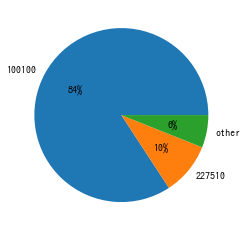

======生産======


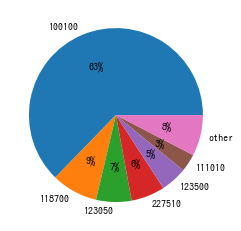

In [17]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "IPAGothic"
PATH_REPORT = pathlib.Path("../reports/")

print("======ワランティ======")
pieplot_topN(df_base_proddiv.groupby("W_PROD_BASE_CD")["n"].sum() / df_base_proddiv.n.sum(),
             2, autopct='%1.f%%', savepath=PATH_REPORT/"warranty_prod_base_pie.png")
print("======生産======")
pieplot_topN(df_base_proddiv_fcok.groupby("V_BASE_CD")["n"].sum() / df_base_proddiv_fcok.n.sum(),
             6, autopct='%1.f%%', savepath=PATH_REPORT/"fcok_base_pie.png")

======ワランティ(処理拠点)======


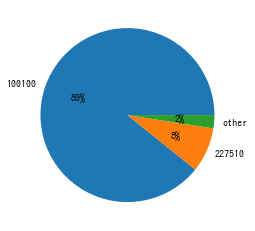

In [18]:
print("======ワランティ(処理拠点)======")
pieplot_topN(df_base_proddiv.groupby("W_BASE_CD")["n"].sum() / df_base_proddiv.n.sum(),
             2, autopct='%1.f%%', savepath=PATH_REPORT/"warranty_base_pie.png")

ワランティデータは国内生産が84%(処理拠点ベースでは89%)。国内生産のモデルのワランティデータに絞って取り組む。

======ワランティ======


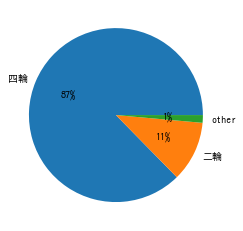

======生産======


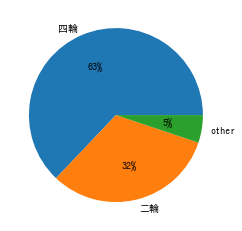

In [20]:
tmp = ((df_base_proddiv
       .loc[df_base_proddiv.W_PROD_BASE_CD == "100100"]
       .groupby("W_PROD_DIV")["n"]
       .sum() \
       / (df_base_proddiv.
          loc[df_base_proddiv.W_PROD_BASE_CD == "100100", "n"]
          .sum()))
       .rename({"A":"二輪","B":"四輪","C":"船外機","D":"発電機", 
                           "E":"ポンプ","F":"OEM","G":"電動車両"}))

print("======ワランティ======")
pieplot_topN(tmp, 2, autopct='%1.f%%',
            savepath=PATH_REPORT/"warranty_prod_div_pie.png")

tmp = ((df_base_proddiv_fcok.groupby("V_PROD_DIV")["n"].sum() \
       / df_base_proddiv["n"].sum())
       .rename({"A":"二輪","B":"四輪","C":"船外機","D":"発電機", 
                           "E":"ポンプ","F":"OEM","G":"電動車両"}))
print("======生産======")
pieplot_topN(tmp, 2, autopct='%1.f%%',
            savepath=PATH_REPORT/"fcok_prod_div_pie.png")

四輪が大半。四輪に限定して取り組む。

In [5]:
%%time
# 生産データのカバー率。少なくとも、全てのワランティはカバーされている部品で分析を行いたい。
# 四輪と二輪、国内生産、FIELD_CLAIM_DIVは1に限定
df_cover_ratio = pd.read_sql(
    """
    select 
        substr(W_PROD_MODEL_CD, 1, 3) as model_cd
        ,substr(W_CAUSAL_PART_NO, 1, 9) as part_cd
        ,count(*) as n_warranty
        ,count(V_VIN) as n_fcok
    from
        dbhaa_all
    left join
        tbhaa_all
    on
        dbhaa_all.W_VIN = tbhaa_all.V_VIN
    where
        W_FIELD_CLAIM_DIV = '1'
        and W_PROD_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
    group by
        model_cd, part_cd    
    """,
    engine
)

CPU times: user 1min 49s, sys: 1min, total: 2min 50s
Wall time: 3min 35s


In [7]:
PATH_PROCESSED = pathlib.Path("../data/processed/")

In [14]:
df_cover_ratio["coverage"] = df_cover_ratio["n_fcok"] / df_cover_ratio["n_warranty"]
df_cover_ratio.to_csv(PATH_PROCESSED/"fcok_cover_ratio.csv")

In [10]:
df_cover_ratio.sort_values(by="n_warranty", ascending=False).head()

model_cd    part_cd  n_warranty  n_fcok  coverage
81053       YJ0  27610-76G      123698  123560  0.998884
106727      YP0  27610-76G       64038   63964  0.998844
57969       YG0  84701-70K       62105   62105  1.000000
58163       YG0  95411-82K       56865   56865  1.000000
71490       YH4  82850-65D       48728   48710  0.999631

In [11]:
df_cover_ratio.shape, df_cover_ratio[df_cover_ratio.coverage == 1].shape

((144461, 5), (116894, 5))

殆どのパーツについては、生産データの方に情報がある(カバーされている）

In [12]:
# パーツでグループして、複数のモデルに含まれるパーツがあるかチェック
df_n_model_same_parts = df_cover_ratio.groupby("part_cd")["n_warranty"]\
        .agg({"n_model_same_parts":len})
df_n_model_same_parts.iloc[:,0].sort_values(ascending=False).head()

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


part_cd
09283-350    88
95896-50G    77
95891-50G    74
38410-661    73
95895-50G    71
Name: n_model_same_parts, dtype: int64

同じパーツが複数のモデルに使用されるケースも多い。

In [13]:
PATH_RAW = pathlib.Path("../data/raw/")
hinmei = pd.read_csv(PATH_RAW/"warranty_fcok"/"fa0010.csv", encoding="CP932")
hinmei.head() # パーツコードの読み替え表

H_HINBAN  H_MATTAN H_NAME           H_HINMEI
0  *1120-CA121          5766         ｸﾗﾝｸｹｰｽ､ｸﾗﾝｸｼﾔﾌﾄ､
1  *1120-CA211          5766         ｸﾗﾝｸｹｰｽ､ｸﾗﾝｸｼﾔﾌﾄ､
2  *1120-CA4AA           716         ｸﾗﾝｸｹｰｽ､ｸﾗﾝｸｼﾔﾌﾄ､
3  *1120-CA4BA           716         ｸﾗﾝｸｹｰｽ､ｸﾗﾝｸｼﾔﾌﾄ､
4  *1120-CA41A           806         ｸﾗﾝｸｹｰｽ､ｸﾗﾝｸｼﾔﾌﾄ､

In [15]:
%%time

# 通期(データ全体)で見た場合の、モデル x パーツ x 月毎のワランティ数を確認
# モデルコードを上3(二輪は4桁)に絞って集計
# 国内で生産された四輪、二輪に限定。

df_warranty_model_part_num_monthly = pd.read_sql(
    """
    select
        substr(W_PROD_MODEL_CD, 1, 3) as model_cd
        ,substr(W_CAUSAL_PART_NO, 1, 9) as part_cd
        ,substr(W_FAILURE_DATE, 1, 6) as month
        ,count(*) as n
    from
        dbhaa_all
    where
        W_PROD_BASE_CD = "100100"
        and W_PROD_DIV = "B"
    group by
        model_cd, part_cd, month;
    """
    , engine)

CPU times: user 33.4 s, sys: 12.4 s, total: 45.8 s
Wall time: 54.7 s


In [106]:
# パーツコードマスタを作成。どの主原因品番がどのモデルに含まれているのかの読み替え表を作成

df_part_model_master = (df_warranty_model_part_num_monthly[["part_cd", "model_cd"]]
                       .set_index(["part_cd", "model_cd"])
                       .sort_index().reset_index()
                       .dropna()
                       .drop_duplicates())

In [107]:
df_part_model_master.tail(10)

part_cd model_cd
1938911  M8316-060      YG0
1938912  M9103-061      YF7
1938913  M9103-061      YH4
1938915  M9168-140      YE9
1938916  M9168-140      YH4
1938917  M9241-250      YH4
1938920  M9246-100      YE9
1938921  M9246-200      YH4
1938926  M9401-240      YH4
1938927  M9402-065      YH4

In [108]:
df_part_model_master.to_csv(PATH_INTERIM_DATA/"part_model_master.csv")

In [19]:
%%time

# 通期(データ全体)で見た場合の、モデル毎の月毎の生産数を確認
# モデルコードを上3(二輪は4桁)に絞って集計
# 国内で生産された四輪、二輪に限定。

df_fcok_model_num_monthly = pd.read_sql(
    """
    select
        case 
            when V_PROD_DIV = "A" then substr(V_PROD_MODEL_CD, 1, 4)
            when V_PROD_DIV = "B" then substr(V_PROD_MODEL_CD, 1, 3)
        else V_PROD_MODEL_CD
        end as PROD_CD
        ,substr(V_FCOK, 1,6) as MONTH
        ,count(*) as N 
    from
        tbhaa_all
    where
        V_BASE_CD = "100100"
        and V_PROD_DIV in ("A", "B")
    group by
        PROD_CD, MONTH;
    """
    , engine)

CPU times: user 36.4 s, sys: 20.6 s, total: 57 s
Wall time: 1min 49s


In [20]:
df_fcok_model_num_monthly\
    .to_csv(PATH_INTERIM_DATA/"df_fcok_model_num_monthly.csv")

In [23]:
df_warranty_model_num_monthly = (df_warranty_model_part_num_monthly
       .fillna("!Unknown")
       .groupby(["model_cd", "month"])["n"]
       .sum()
       .reset_index())

In [25]:
df_warranty_model_part_num_monthly.month.max()

'201904'

In [30]:
model_top = (df_warranty_model_num_monthly
             .groupby("model_cd")["n"]
             .sum()
             .sort_values(ascending=False))

In [33]:
from datetime import datetime

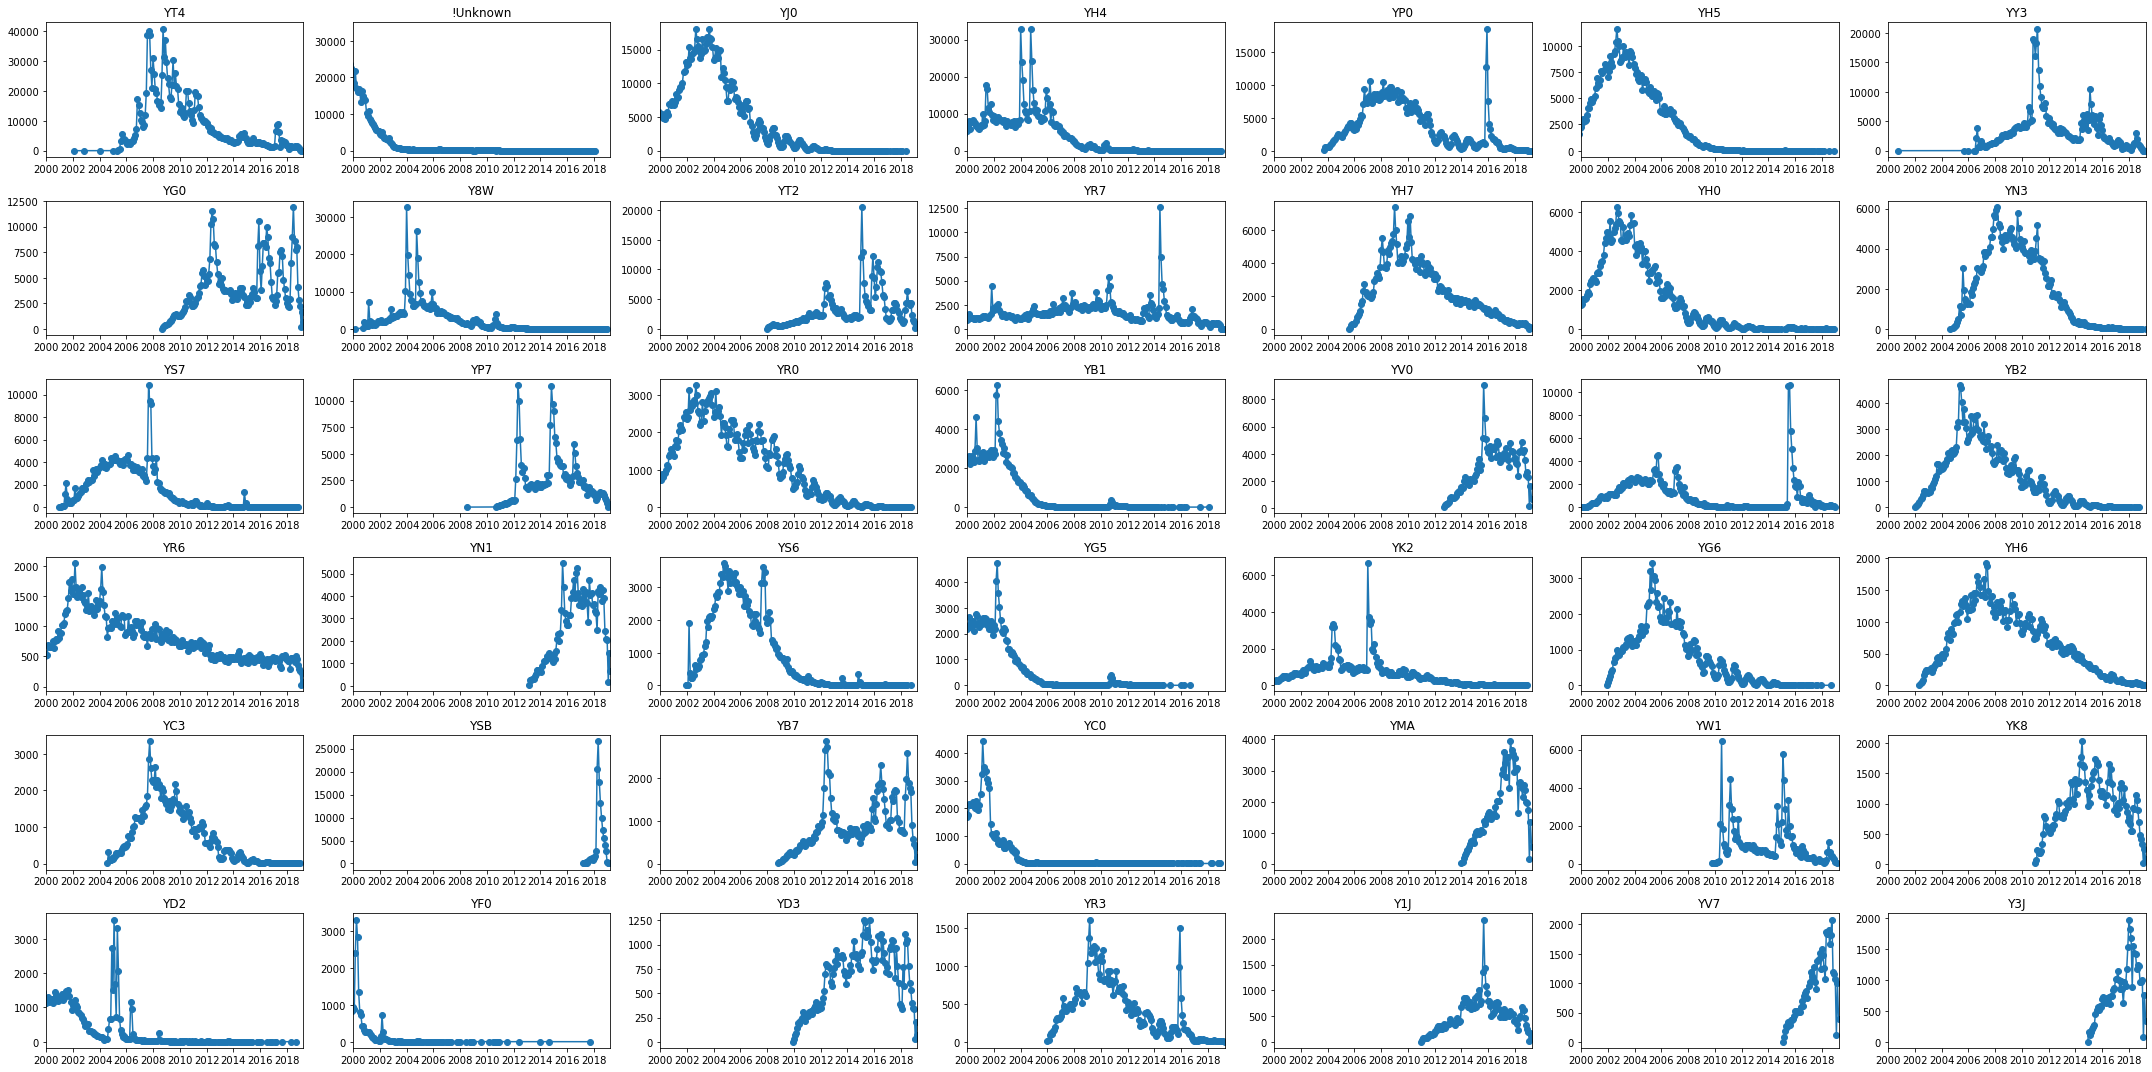

In [34]:
tmp = df_warranty_model_num_monthly.copy()
tmp["month"] = pd.to_datetime(tmp["month"].astype(str) + "01")
tmp = tmp.set_index("month")

plt.figure(figsize=(30,15))
for i, m in enumerate(model_top.index[:42]):
    plt.subplot(6,7,i+1)
    val = tmp.loc[tmp.model_cd == m, "n"]
    plt.plot(val.index, val, "o-")
    plt.title(m)
    plt.xlim(datetime(2000,1,1),datetime(2019,4,1))
plt.tight_layout()
plt.show()

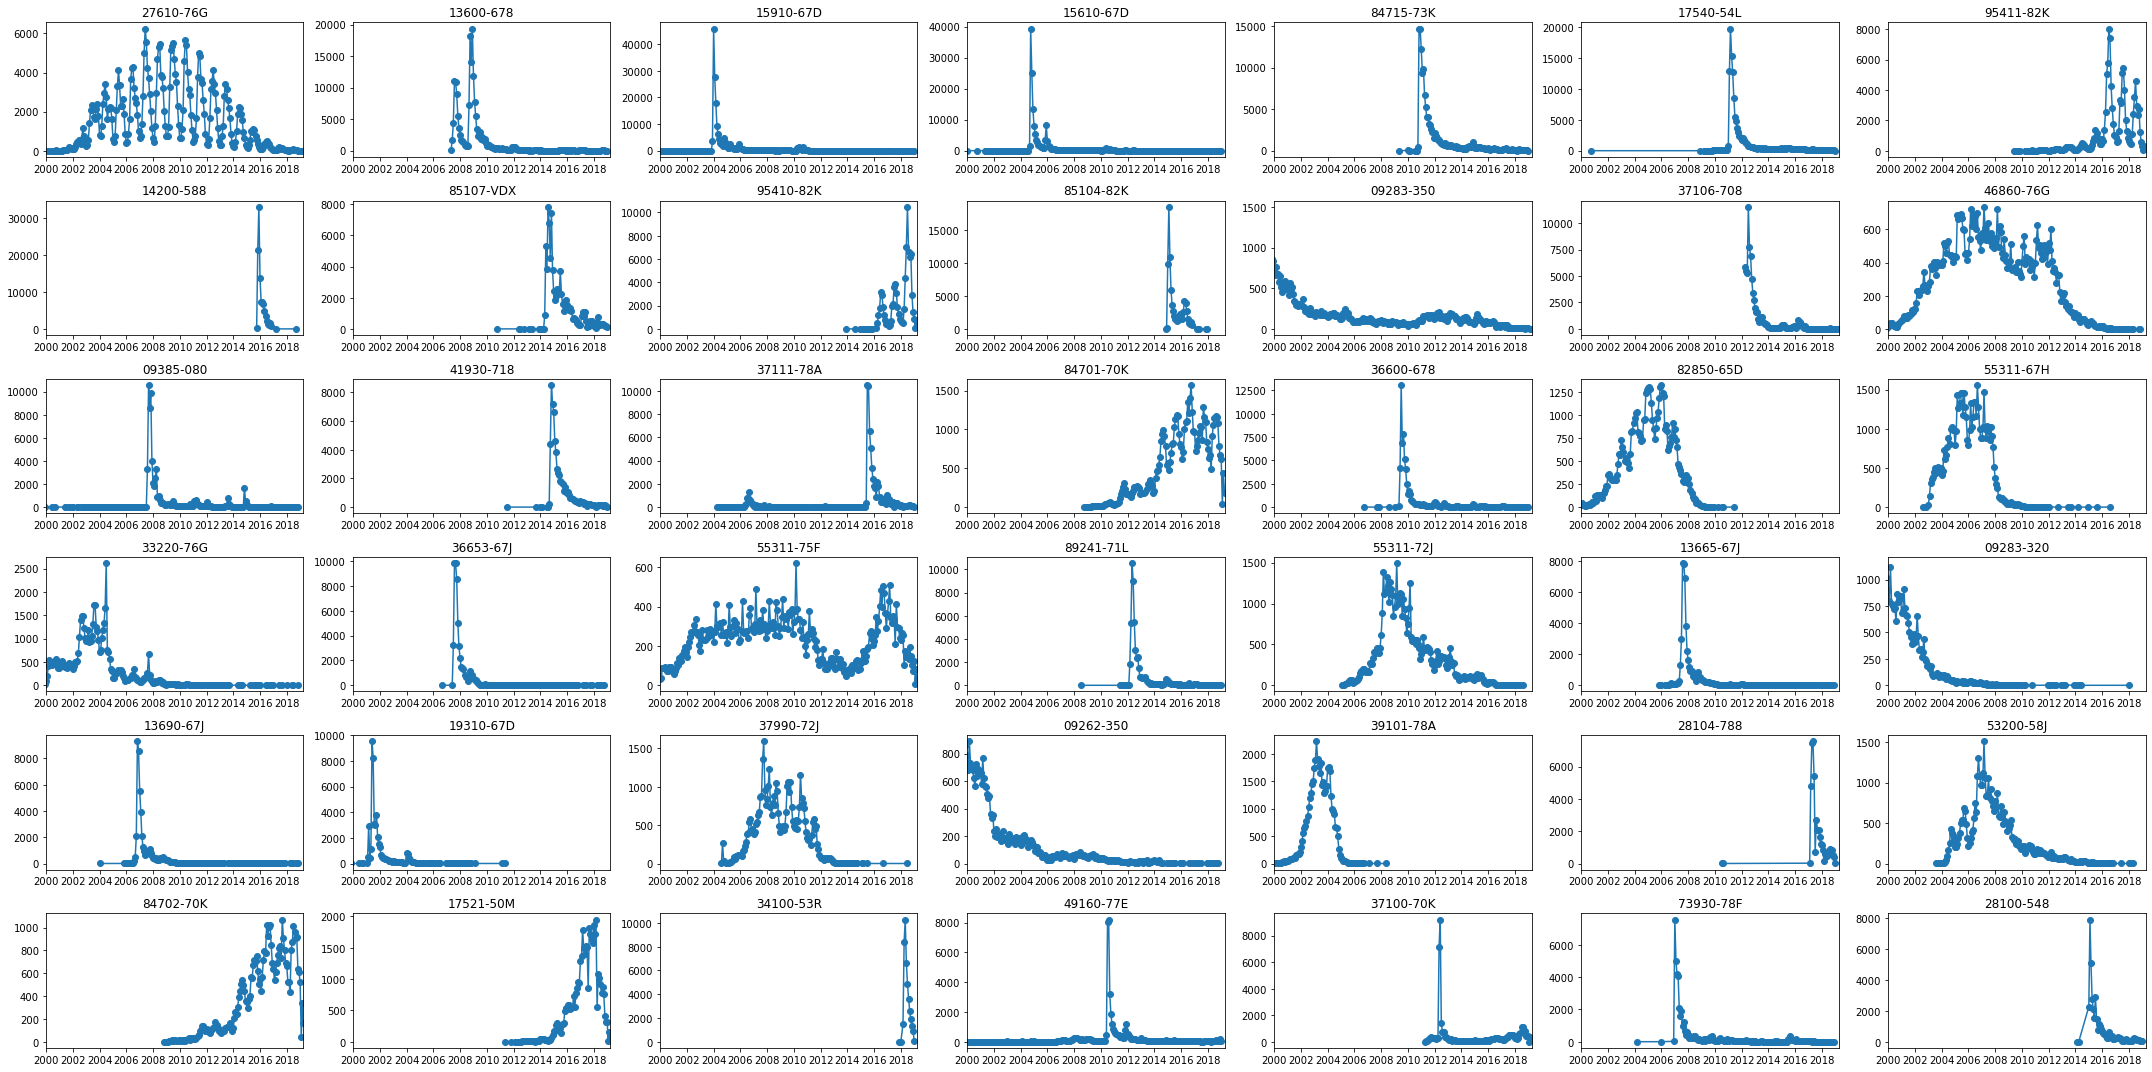

In [48]:
df_warranty_part_num_monthly = (df_warranty_model_part_num_monthly
                                .fillna("!Unknown")
                                .groupby(["part_cd", "month"])["n"]
                                .sum()
                                .reset_index())
tmp = df_warranty_part_num_monthly.copy()
tmp["month"] = pd.to_datetime(tmp["month"].astype(str) + "01")
tmp = tmp.set_index("month")

plt.figure(figsize=(30,15))
for i, m in enumerate(parts_top.index[:42]):
    plt.subplot(6,7,i+1)
    val = tmp.loc[tmp.part_cd == m, "n"]
    plt.plot(val.index, val, "o-")
    plt.title(m)
    plt.xlim(datetime(2000,1,1),datetime(2019,4,1))
plt.tight_layout()
plt.show()

In [49]:
%%time

# 通期(データ全体)で見た場合の、モデル x パーツ x 月毎のワランティ数を確認
# モデルコードを上3(二輪は4桁)に絞って集計
# 国内で生産された四輪、二輪に限定。

df_warranty_model_part_num_daily = pd.read_sql(
    """
    select
        substr(W_PROD_MODEL_CD, 1, 3) as model_cd
        ,substr(W_CAUSAL_PART_NO, 1, 9) as part_cd
        ,W_FAILURE_DATE as date
        ,count(*) as n
    from
        dbhaa_all
    where
        W_PROD_BASE_CD = "100100"
        and W_PROD_DIV = "B"
    group by
        model_cd, part_cd, date;
    """
    , engine)

CPU times: user 47.1 s, sys: 14.8 s, total: 1min 1s
Wall time: 1min 13s


In [50]:
df_warranty_model_part_num_daily.shape

(6650983, 4)

In [52]:
df_warranty_model_part_num_daily.head()

model_cd    part_cd      date  n
0     None  *0000-000  20030122  1
1     None  *1110-CT5  20000616  1
2     None  *1110-CT5  20010706  1
3     None  *1110-DC5  20010110  1
4     None  *1110-MA6  20000205  1

In [54]:
df_warranty_model_part_num_daily["date"] = pd.to_datetime(df_warranty_model_part_num_daily["date"],
                                                         errors="coerce")

In [55]:
df_warranty_model_part_num_daily.date.isna().sum()

4

In [56]:
df_warranty_model_part_num_daily.dropna(subset=["date"], inplace=True)

In [57]:
df_warranty_part_num_weekly = (df_warranty_model_part_num_daily
                                .fillna("!Unknown")
                                .groupby(["part_cd", pd.Grouper(key="date", freq="W-MON")])["n"]
                                .sum()
                                .reset_index())
df_warranty_part_num_weekly["date"] = df_warranty_part_num_weekly["date"] - pd.to_timedelta(7, unit="d")
df_warranty_part_num_weekly.rename(columns={"date":"week"}, inplace=True)

In [59]:
df_warranty_part_num_weekly.head()

part_cd       week  n
0  *0000-000 2002-05-13  1
1  *0000-000 2002-06-24  1
2  *0000-000 2002-11-25  1
3  *0000-000 2003-01-20  1
4  *0000-000 2003-05-12  1

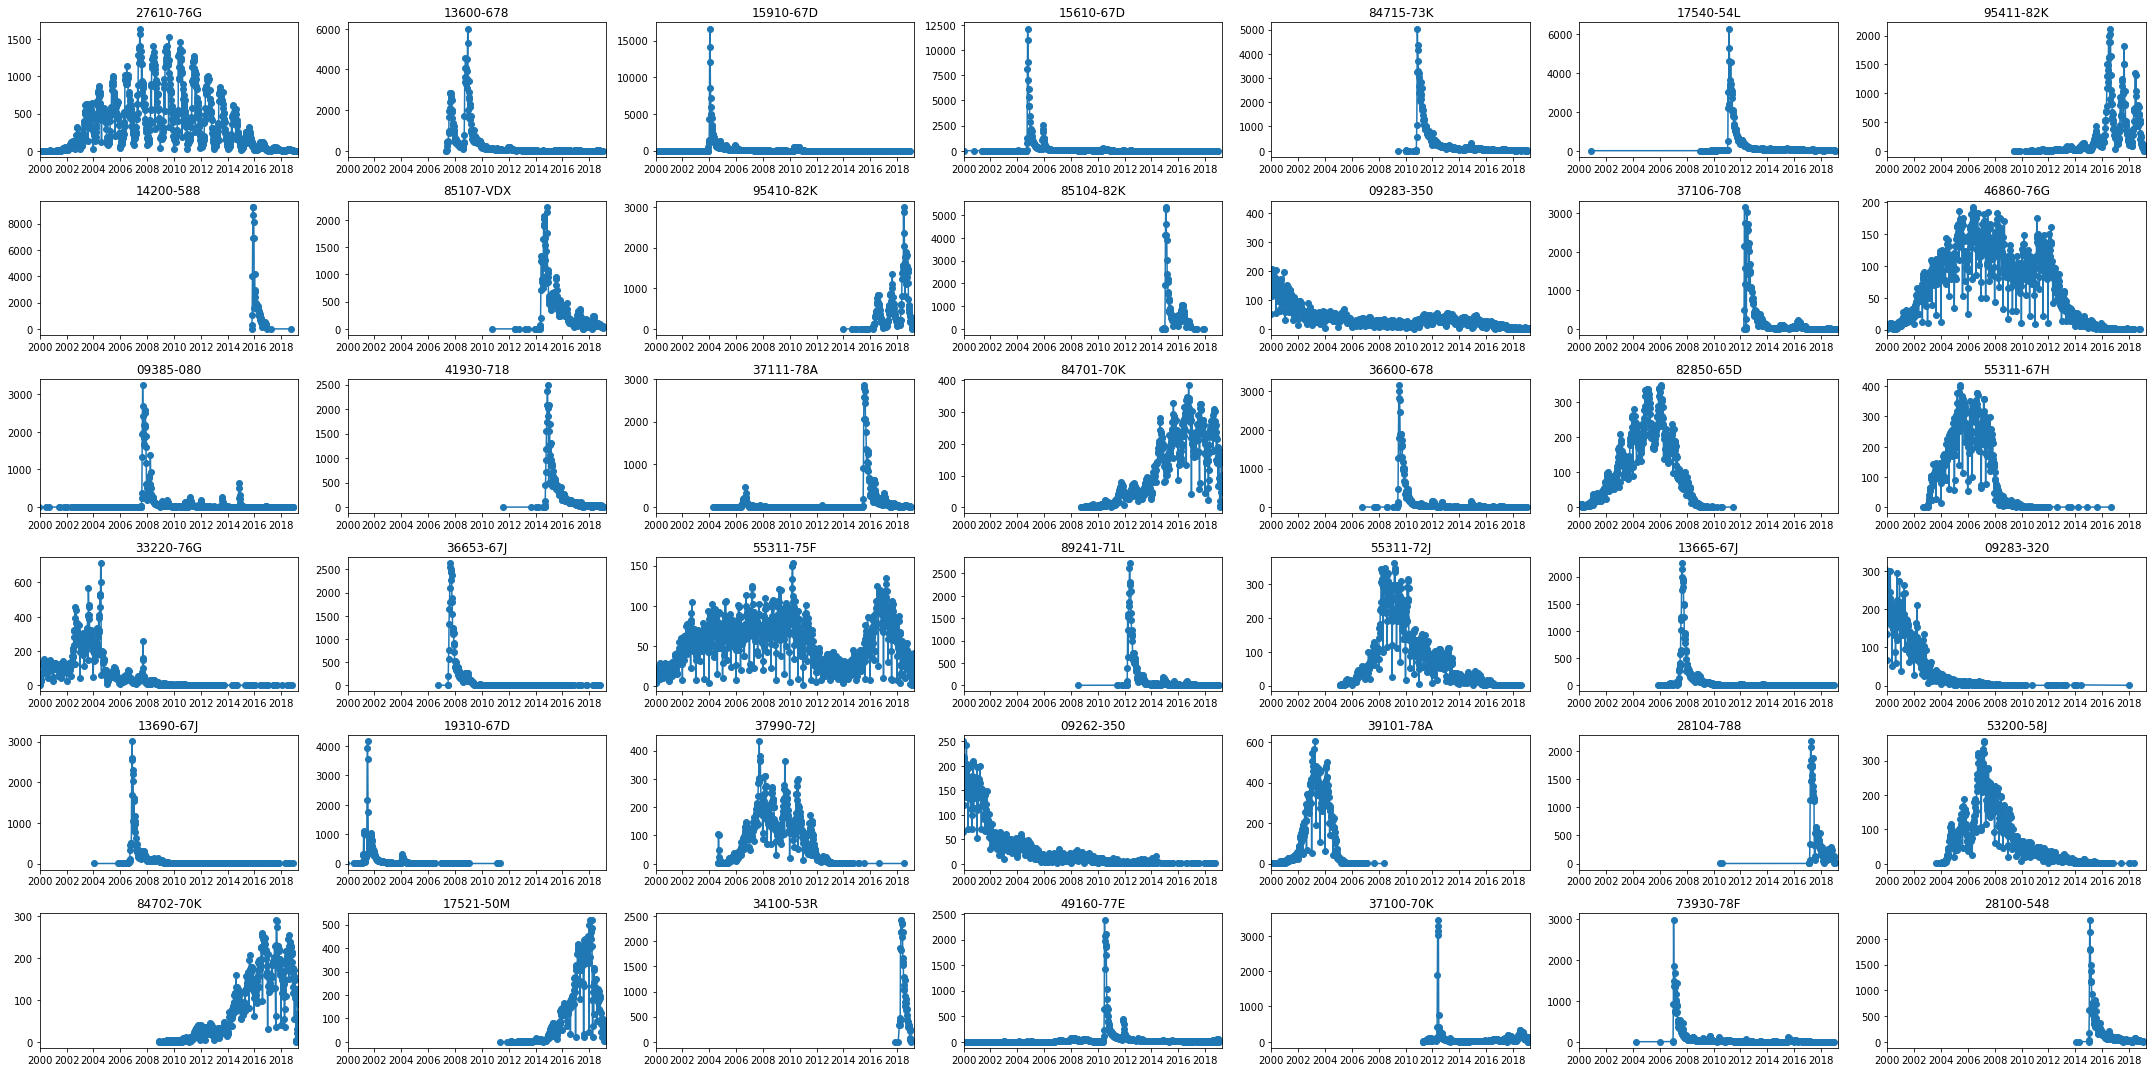

In [60]:
tmp = df_warranty_part_num_weekly.copy()
tmp = tmp.set_index("week")

plt.figure(figsize=(30,15))
for i, m in enumerate(parts_top.index[:42]):
    plt.subplot(6,7,i+1)
    val = tmp.loc[tmp.part_cd == m, "n"]
    plt.plot(val.index, val, "o-")
    plt.title(m)
    plt.xlim(datetime(2000,1,1),datetime(2019,4,1))
plt.tight_layout()
plt.show()

In [35]:
%%time

# 通期(データ全体)で見た場合の、モデル x パーツ x 経過月毎のワランティ数を確認
# モデルコードを上3(二輪は4桁)に絞って集計
# 国内で生産された四輪、二輪に限定。

df_warranty_model_part_num_month_passed = pd.read_sql(
    """
    select
        substr(W_PROD_MODEL_CD, 1, 3) as model_cd
        ,substr(W_CAUSAL_PART_NO, 1, 9) as part_cd
        ,W_SALES_TO_FAILURE as month_passed
        ,count(*) as n
    from
        dbhaa_all
    where
        W_PROD_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
    group by
        model_cd, part_cd, month_passed;
    """
    , engine)

CPU times: user 31.3 s, sys: 11.9 s, total: 43.2 s
Wall time: 55.5 s


In [36]:
df_warranty_model_part_num_month_passed.to_csv(PATH_INTERIM_DATA/"df_warranty_model_part_num_month_passed.csv")

In [37]:
df_warranty_model_num_month_passed = (df_warranty_model_part_num_month_passed
       .fillna("!Unknown")
       .groupby(["model_cd", "month_passed"])["n"]
       .sum()
       .reset_index())

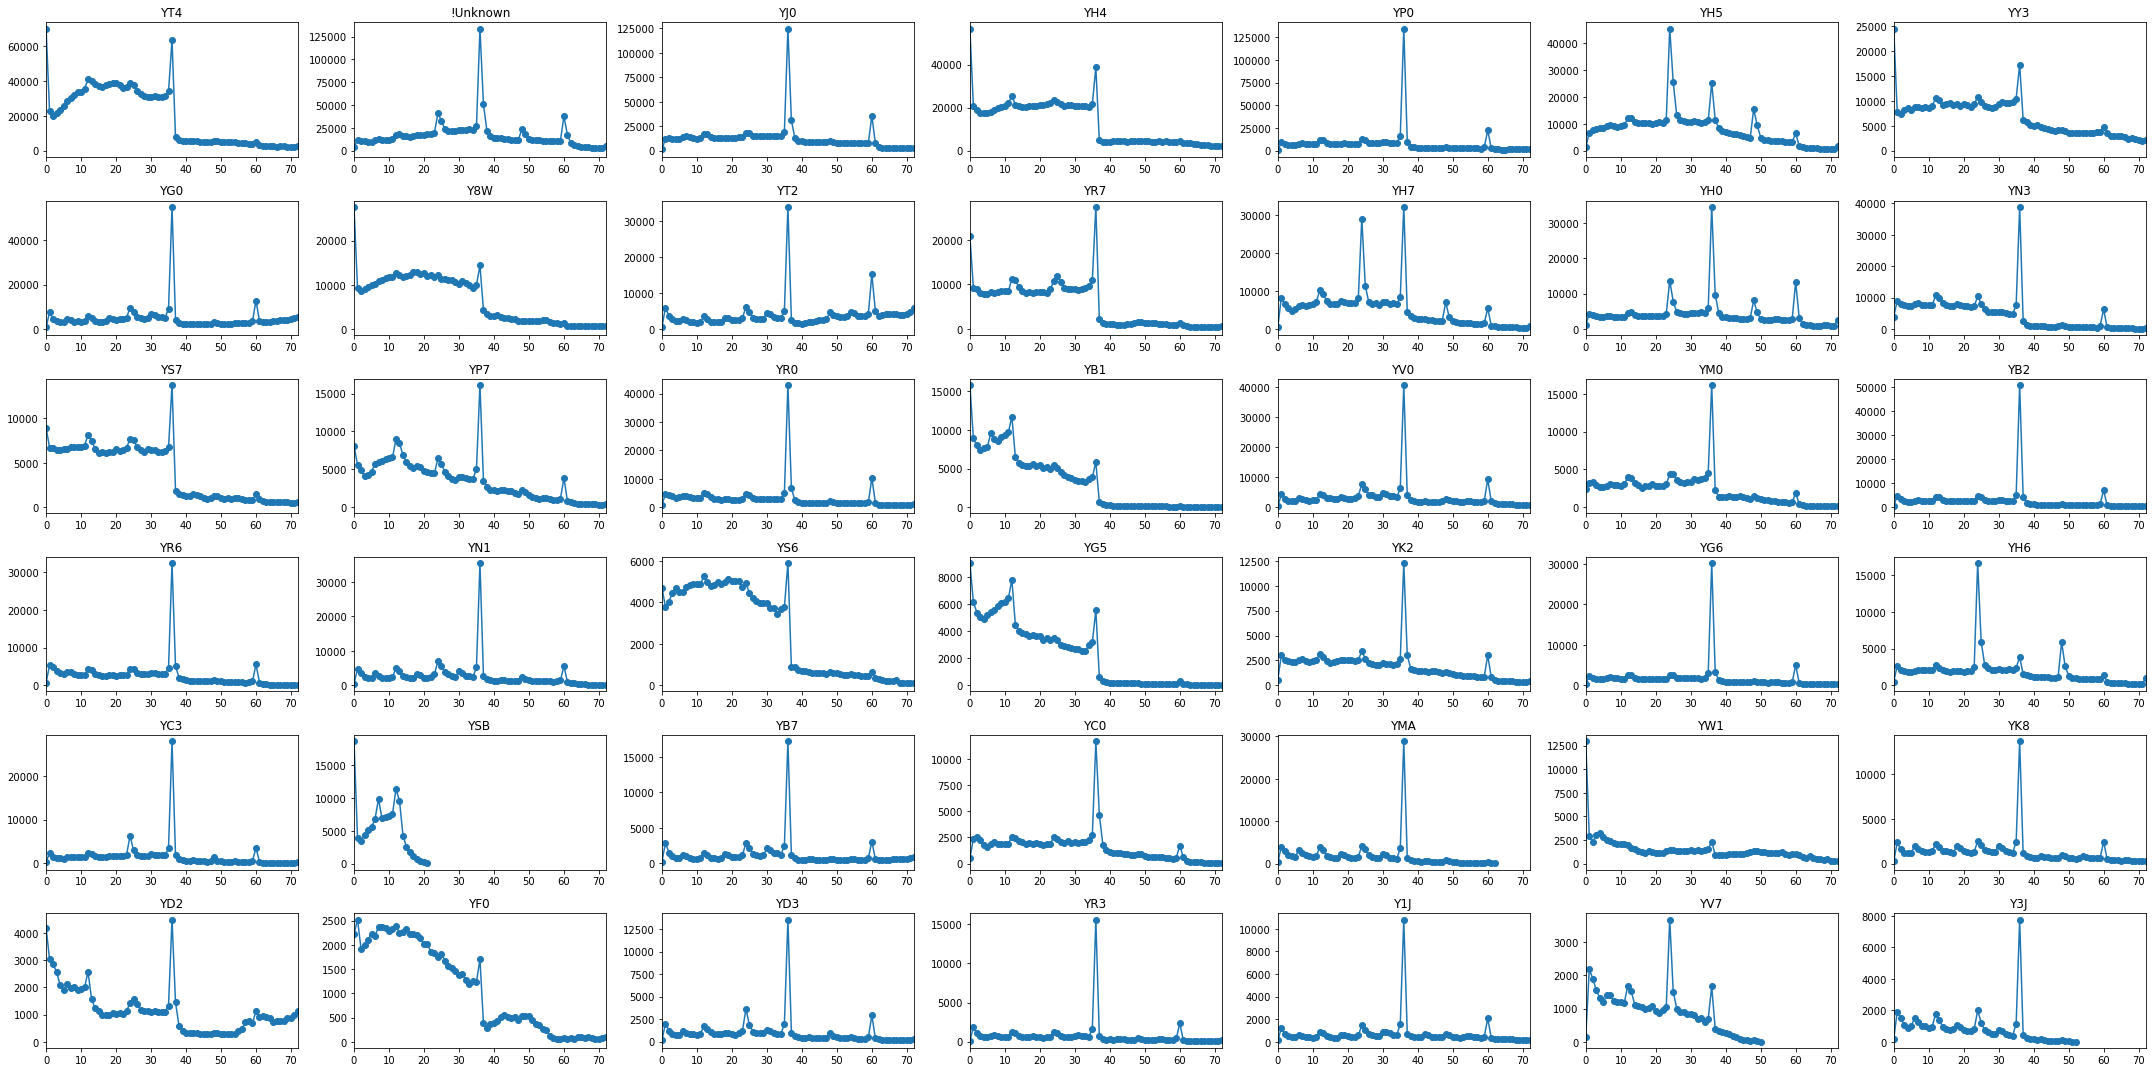

In [38]:
tmp = df_warranty_model_num_month_passed.copy()
tmp["month_passed"] = tmp["month_passed"].astype(int)
tmp = tmp.set_index("month_passed")

plt.figure(figsize=(30,15))
for i, m in enumerate(model_top.index[:42]):
    plt.subplot(6,7,i+1)
    val = tmp.loc[tmp.model_cd == m, "n"]
    plt.plot(val.index, val, "o-")
    plt.title(m)
    plt.xlim(0,72)
plt.tight_layout()
plt.show()

In [39]:
parts_top = (df_warranty_model_part_num_month_passed
       .groupby("part_cd")["n"]
       .sum()
       .sort_values(ascending=False))

In [47]:
df_warranty_part_num_month_passed = (df_warranty_model_part_num_month_passed
       .fillna("!Unknown")
       .groupby(["part_cd", "month_passed"])["n"]
       .sum()
       .reset_index())
tmp = df_warranty_part_num_month_passed.copy()
tmp["month_passed"] = tmp["month_passed"].astype(int)
tmp = tmp.set_index("month_passed")

plt.figure(figsize=(30,15))
for i, m in enumerate(parts_top.index[:42]):
    plt.subplot(6,7,i+1)
    val = tmp.loc[tmp.part_cd == m, "n"]
    plt.plot(val.index, val, "o-")
    plt.title(m)
    plt.xlim(0,72)
plt.tight_layout()
plt.show()

In [61]:
%%time

# 通期(データ全体)で見た場合の、モデル毎の月毎の生産数を確認
# モデルコードを上3(二輪は4桁)に絞って集計
# 国内で生産された四輪、二輪に限定。

df_fcok_model_num_daily = pd.read_sql(
    """
    select
        substr(V_PROD_MODEL_CD, 1, 3) as model_cd
        ,V_FCOK as date
        ,count(*) as n
    from
        tbhaa_all
    where
        V_BASE_CD = "100100"
        and V_PROD_DIV = "B"
    group by
        model_cd, date;
    """
    , engine)

CPU times: user 25.9 s, sys: 14.9 s, total: 40.8 s
Wall time: 1min 28s


In [62]:
df_fcok_model_num_daily.head()

model_cd      date  n
0     None  20010521  8
1     None  20010523  1
2     None  20010604  1
3     None  20010605  3
4     None  20010611  4

In [63]:
df_fcok_model_num_daily["date"] = pd.to_datetime(df_fcok_model_num_daily.date,
                                                 errors="coerce")

In [64]:
df_fcok_model_num_daily.date.isna().sum()

0

In [65]:
df_fcok_model_num_weekly = (df_fcok_model_num_daily
                            .fillna("!Unknown")
                            .groupby(["model_cd", pd.Grouper(key="date", freq="W-MON")])["n"]
                            .sum()
                            .reset_index())
df_fcok_model_num_weekly["date"] = df_fcok_model_num_weekly.date - pd.to_timedelta(7, unit="d")                      
df_fcok_model_num_weekly.rename(columns={"date":"week"}, inplace=True)

In [66]:
df_fcok_model_num_weekly.shape

(21742, 3)

In [67]:
df_fcok_model_num_monthly.head()

PROD_CD   MONTH    N
0    None  200105    9
1    None  200106  108
2    None  200107   44
3    None  200108   42
4    None  200109   91

In [68]:
df_fcok_model_num_monthly["MONTH"] = pd.to_datetime(df_fcok_model_num_monthly.MONTH.astype(str) + "01")

In [71]:
# 累積生産台数(モデル毎)
df_fcok_model_num_running_monthly = (df_fcok_model_num_monthly
                                      .copy()
                                      .fillna("!Unknown")
                                      .sort_values(by=["PROD_CD", "MONTH"]))
df_fcok_model_num_running_monthly["running"] = \
                    (df_fcok_model_num_running_monthly
                     .groupby(["PROD_CD"])["N"]
                     .transform(lambda x: x.cumsum()))

In [72]:
df_fcok_model_num_running_monthly.head()

PROD_CD      MONTH    N  running
0  !Unknown 2001-05-01    9        9
1  !Unknown 2001-06-01  108      117
2  !Unknown 2001-07-01   44      161
3  !Unknown 2001-08-01   42      203
4  !Unknown 2001-09-01   91      294

In [75]:
tmp = df_fcok_model_num_running_monthly.copy()
tmp = tmp.set_index("MONTH")

fig = plt.figure(figsize=(30,15))
for i, m in enumerate(model_top.index[:42]):
    ax1 = fig.add_subplot(6,7,i+1)
    val1 = tmp.loc[tmp.PROD_CD == m, "N"]
    val2 = tmp.loc[tmp.PROD_CD == m, "running"]
    ax1.plot(val1.index, val1, "o-")
    ax1.set_title(m)
    ax1.set_xlim(datetime(2000,1,1),datetime(2019,4,1))
    
    ax2 = ax1.twinx()
    ax2.plot(val2.index, val2, "-", color="tab:red")
    ax2.set_xlim(datetime(2000,1,1),datetime(2019,4,1))
    
plt.tight_layout()
plt.show()

In [77]:
# 累積生産台数(モデル毎)
df_fcok_model_num_running_weekly = (df_fcok_model_num_weekly
                                      .copy()
                                      .fillna("!Unknown")
                                      .sort_values(by=["model_cd", "week"]))
df_fcok_model_num_running_weekly["running"] = \
                    (df_fcok_model_num_running_weekly
                     .groupby(["model_cd"])["n"]
                     .transform(lambda x: x.cumsum()))

In [78]:
df_fcok_model_num_running_weekly.head()

model_cd       week   n  running
0  !Unknown 2001-05-14   8        8
1  !Unknown 2001-05-21   1        9
2  !Unknown 2001-05-28   1       10
3  !Unknown 2001-06-04   7       17
4  !Unknown 2001-06-11  28       45

In [80]:
tmp = df_fcok_model_num_running_weekly.copy()
tmp = tmp.set_index("week")

fig = plt.figure(figsize=(30,15))
for i, m in enumerate(model_top.index[:42]):
    ax1 = fig.add_subplot(6,7,i+1)
    val1 = tmp.loc[tmp.model_cd == m, "n"]
    val2 = tmp.loc[tmp.model_cd == m, "running"]
    ax1.plot(val1.index, val1, "o-")
    ax1.set_title(m)
    ax1.set_xlim(datetime(2000,1,1),datetime(2019,4,1))
    
    ax2 = ax1.twinx()
    ax2.plot(val2.index, val2, "-", color="tab:red")
    ax2.set_xlim(datetime(2000,1,1),datetime(2019,4,1))
    
plt.tight_layout()
plt.show()

In [82]:
df_part_model_master.set_index("part_cd", inplace=True)

In [83]:
df_fcok_model_num_running_monthly.head()

PROD_CD      MONTH    N  running
0  !Unknown 2001-05-01    9        9
1  !Unknown 2001-06-01  108      117
2  !Unknown 2001-07-01   44      161
3  !Unknown 2001-08-01   42      203
4  !Unknown 2001-09-01   91      294

In [84]:
df_fcok_model_num_monthly.MONTH.min()

Timestamp('1994-04-01 00:00:00')

In [139]:
d = pd.date_range(datetime(1994,4,1), datetime(2019, 4, 1), freq="MS").to_frame(name="month")

In [133]:
df_warranty_part_num_monthly["month"] = pd.to_datetime(df_warranty_part_num_monthly.month.astype(str) + "01",
                                                      errors="coerce")

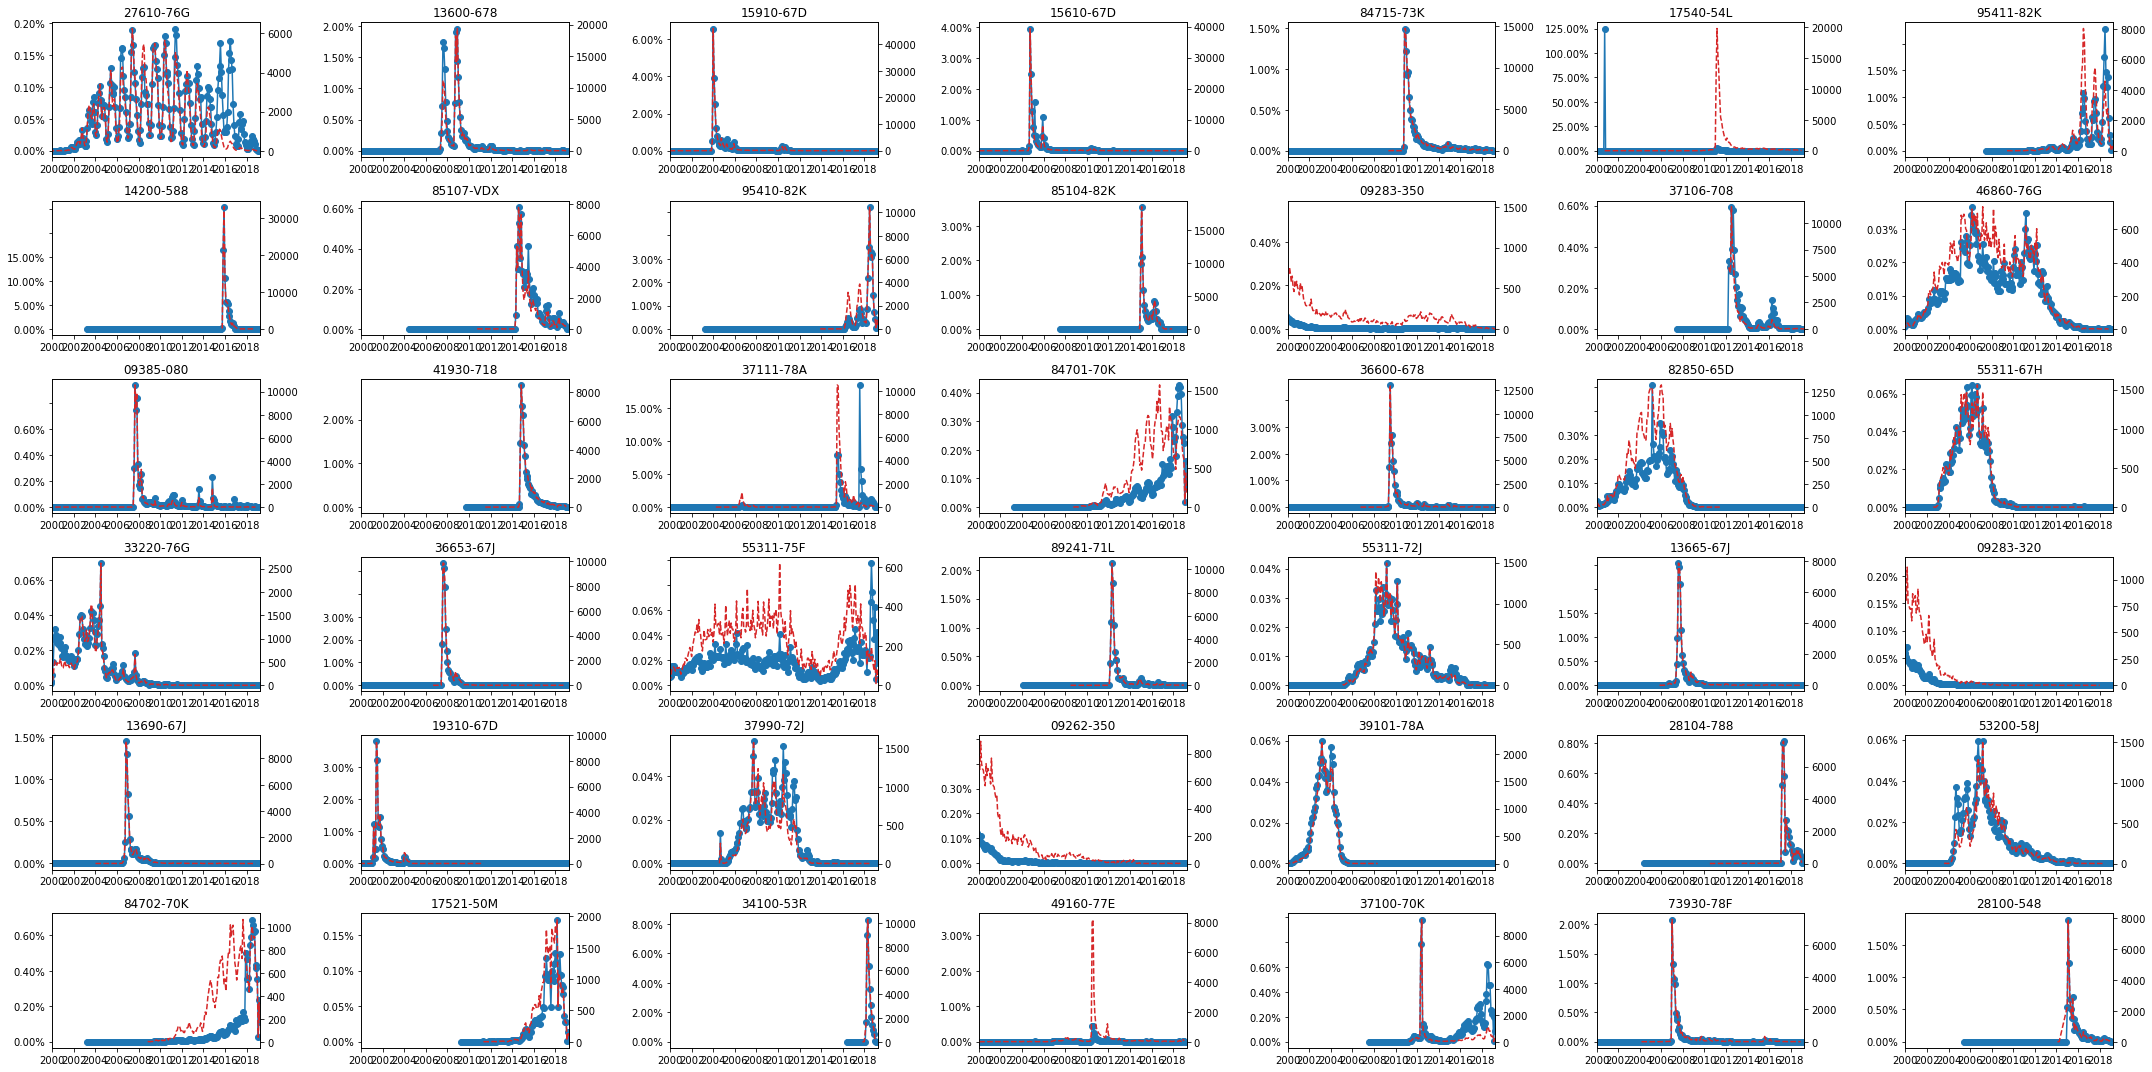

In [171]:
fig = plt.figure(figsize=(30,15))

for i, p in enumerate(parts_top.index[:42]):
    ax = fig.add_subplot(6, 7, i+1)
    model_having_parts = df_part_model_master[df_part_model_master.part_cd == p]
    tmp_total_running = (model_having_parts.merge(df_fcok_model_num_running_monthly,
                                                 left_on="model_cd", right_on="PROD_CD", how="inner")
                         .groupby("MONTH")["running"]
                         .sum()
                         .to_frame(name="running")
                         .reset_index()
                         .rename(columns={"MONTH":"month"}))
    tmp_total_running = (d.merge(tmp_total_running, on="month", how="left")
                         .fillna(method="ffill")
                         .set_index("month"))
    tmp_warranty = df_warranty_part_num_monthly.loc[df_warranty_part_num_monthly.part_cd == p,
                                                     ["month", "n"]]
    
    tmp_warranty_m = d.merge(tmp_warranty, on="month", how="left").fillna(0).set_index("month")
    tmp = tmp_warranty_m["n"] / tmp_total_running["running"]
    ax.plot(tmp.index, tmp.values, "o-")
    plt.title(p)
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
    ax.set_xlim(datetime(2000,1,1), datetime(2019,4,1))
    ax2 = ax.twinx()
    ax2.plot(tmp_warranty.month, tmp_warranty.n, "--", color="tab:red")
    ax2.set_xlim(datetime(2000,1,1), datetime(2019,4,1))
plt.tight_layout()
plt.show()

In [187]:
dw = pd.date_range(datetime(1994,3,28), datetime(2019, 4, 8), freq="W-MON").to_frame(name="week")

In [188]:
dw.head()

week
1994-03-28 1994-03-28
1994-04-04 1994-04-04
1994-04-11 1994-04-11
1994-04-18 1994-04-18
1994-04-25 1994-04-25

In [193]:
tmp_total_running.head()

week  running
0 1994-04-04        1
1 1994-04-18        1
2 1994-05-16        3
3 1994-06-20       16
4 1994-06-27       35

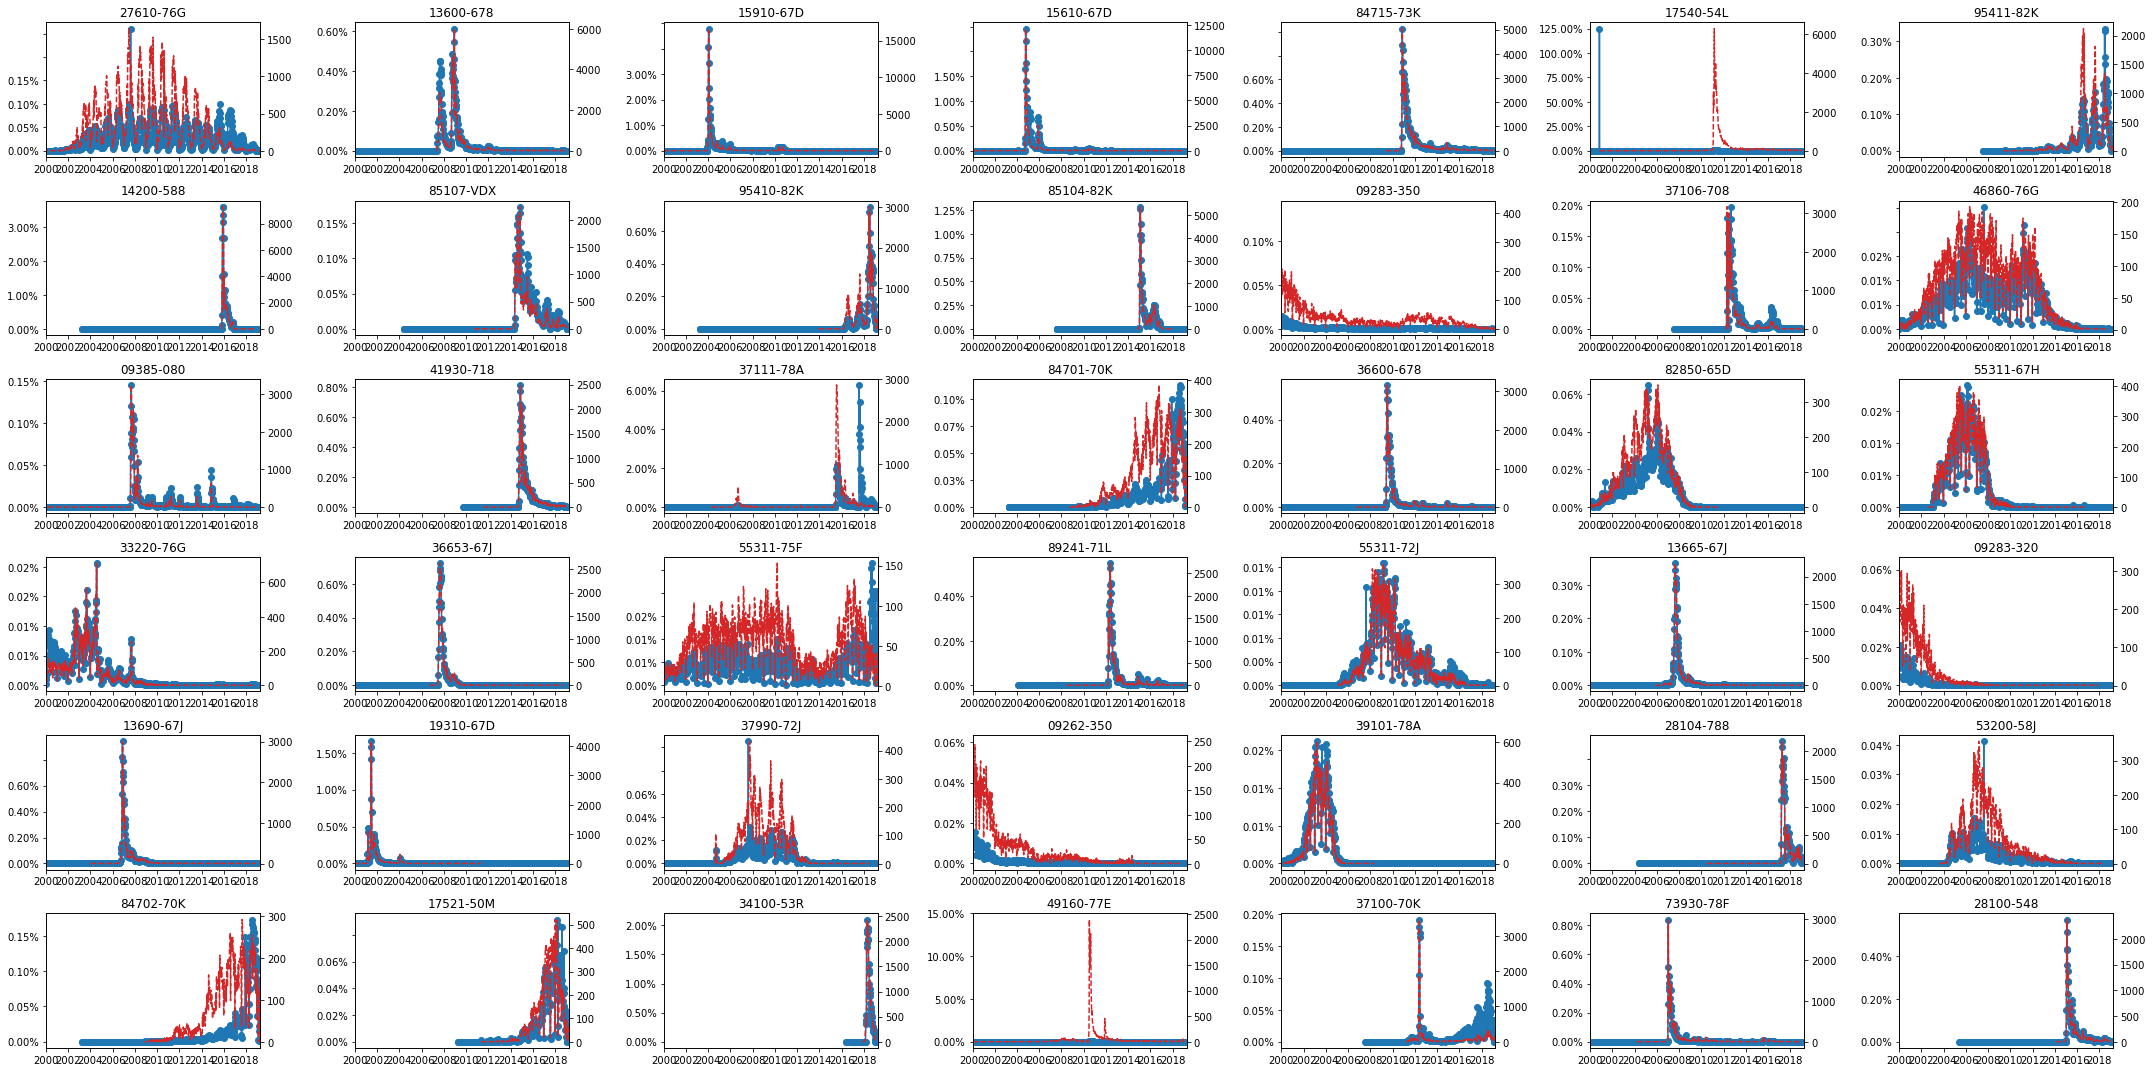

In [194]:
fig = plt.figure(figsize=(30,15))

for i, p in enumerate(parts_top.index[:42]):
    ax = fig.add_subplot(6, 7, i+1)
    model_having_parts = df_part_model_master[df_part_model_master.part_cd == p]
    tmp_total_running = (model_having_parts.merge(df_fcok_model_num_running_weekly,
                                                 on="model_cd", how="inner")
                         .groupby("week")["running"]
                         .sum()
                         .to_frame(name="running")
                         .reset_index())
    tmp_total_running = (dw.merge(tmp_total_running, on="week", how="left")
                         .fillna(method="ffill")
                         .set_index("week"))
    tmp_warranty = df_warranty_part_num_weekly.loc[df_warranty_part_num_weekly.part_cd == p,
                                                     ["week", "n"]]
    
    tmp_warranty_m = dw.merge(tmp_warranty, on="week", how="left").fillna(0).set_index("week")
    tmp = tmp_warranty_m["n"] / tmp_total_running["running"]
    ax.plot(tmp.index, tmp.values, "o-")
    plt.title(p)
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
    ax.set_xlim(datetime(2000,1,1), datetime(2019,4,1))
    ax2 = ax.twinx()
    ax2.plot(tmp_warranty.week, tmp_warranty.n, "--", color="tab:red")
    ax2.set_xlim(datetime(2000,1,1), datetime(2019,4,1))
plt.tight_layout()
plt.show()

In [197]:
def month_passed(series, baseyear, basemonth):
    return 12 * (baseyear - series.dt.year) + (basemonth - series.dt.month)

df_fcok_model_num_running_month_passed = df_fcok_model_num_running_monthly.copy()
df_fcok_model_num_running_month_passed["MONTH"] = month_passed(df_fcok_model_num_running_month_passed.MONTH,
                                              2019, 4)

In [200]:
dp = pd.DataFrame({"month":list(range(299))})

In [201]:
df_warranty_part_num_month_passed.head()

part_cd  month_passed  n
0  *0000-000             1  3
1  *0000-000             2  3
2  *0000-000             3  2
3  *0000-000             4  3
4  *0000-000             5  1

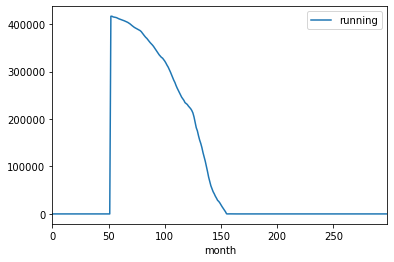

In [206]:
tmp_total_running.plot()

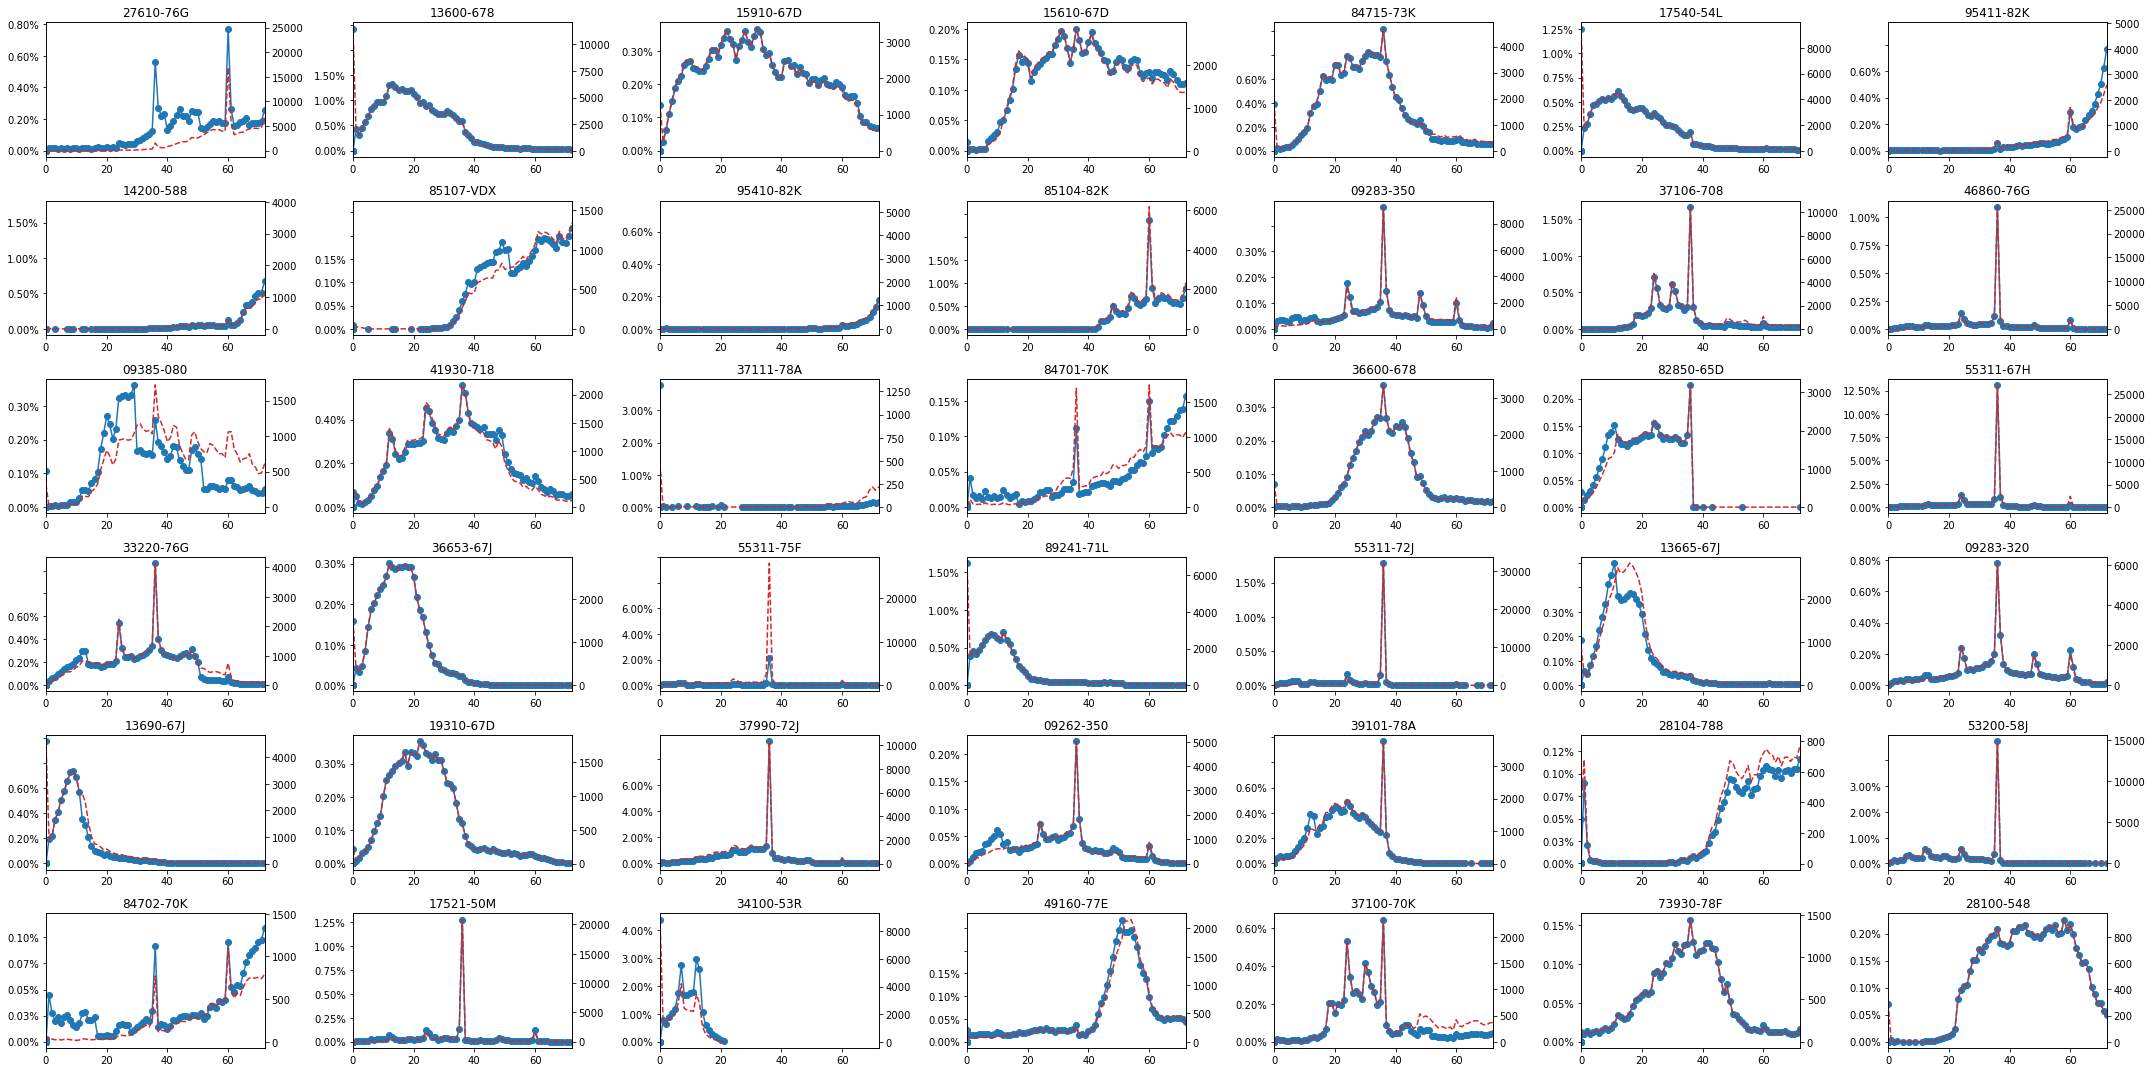

In [207]:
fig = plt.figure(figsize=(30,15))

for i, p in enumerate(parts_top.index[:42]):
    ax = fig.add_subplot(6, 7, i+1)
    model_having_parts = df_part_model_master[df_part_model_master.part_cd == p]
    tmp_total_running = (model_having_parts.merge(df_fcok_model_num_running_month_passed,
                                                 left_on="model_cd", right_on="PROD_CD", how="inner")
                         .groupby("MONTH")["running"]
                         .sum()
                         .to_frame(name="running")
                         .reset_index()
                         .rename(columns={"MONTH":"month"}))
    tmp_total_running = (dp.merge(tmp_total_running, on="month", how="left")
                         .fillna(method="bfill")
                         .set_index("month"))
    tmp_warranty = df_warranty_part_num_month_passed.loc[df_warranty_part_num_month_passed.part_cd == p,
                                                     ["month_passed", "n"]]
    
    tmp_warranty_m = (dp.merge(tmp_warranty, left_on="month", right_on="month_passed", how="left")
                        .fillna(0).set_index("month_passed"))
    tmp = tmp_warranty_m["n"] / tmp_total_running["running"]
    ax.plot(tmp.index, tmp.values, "o-")
    plt.title(p)
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
    ax.set_xlim(0, 72)
    ax2 = ax.twinx()
    ax2.plot(tmp_warranty.month_passed, tmp_warranty.n, "--", color="tab:red")
    ax2.set_xlim(0, 72)
plt.tight_layout()
plt.show()

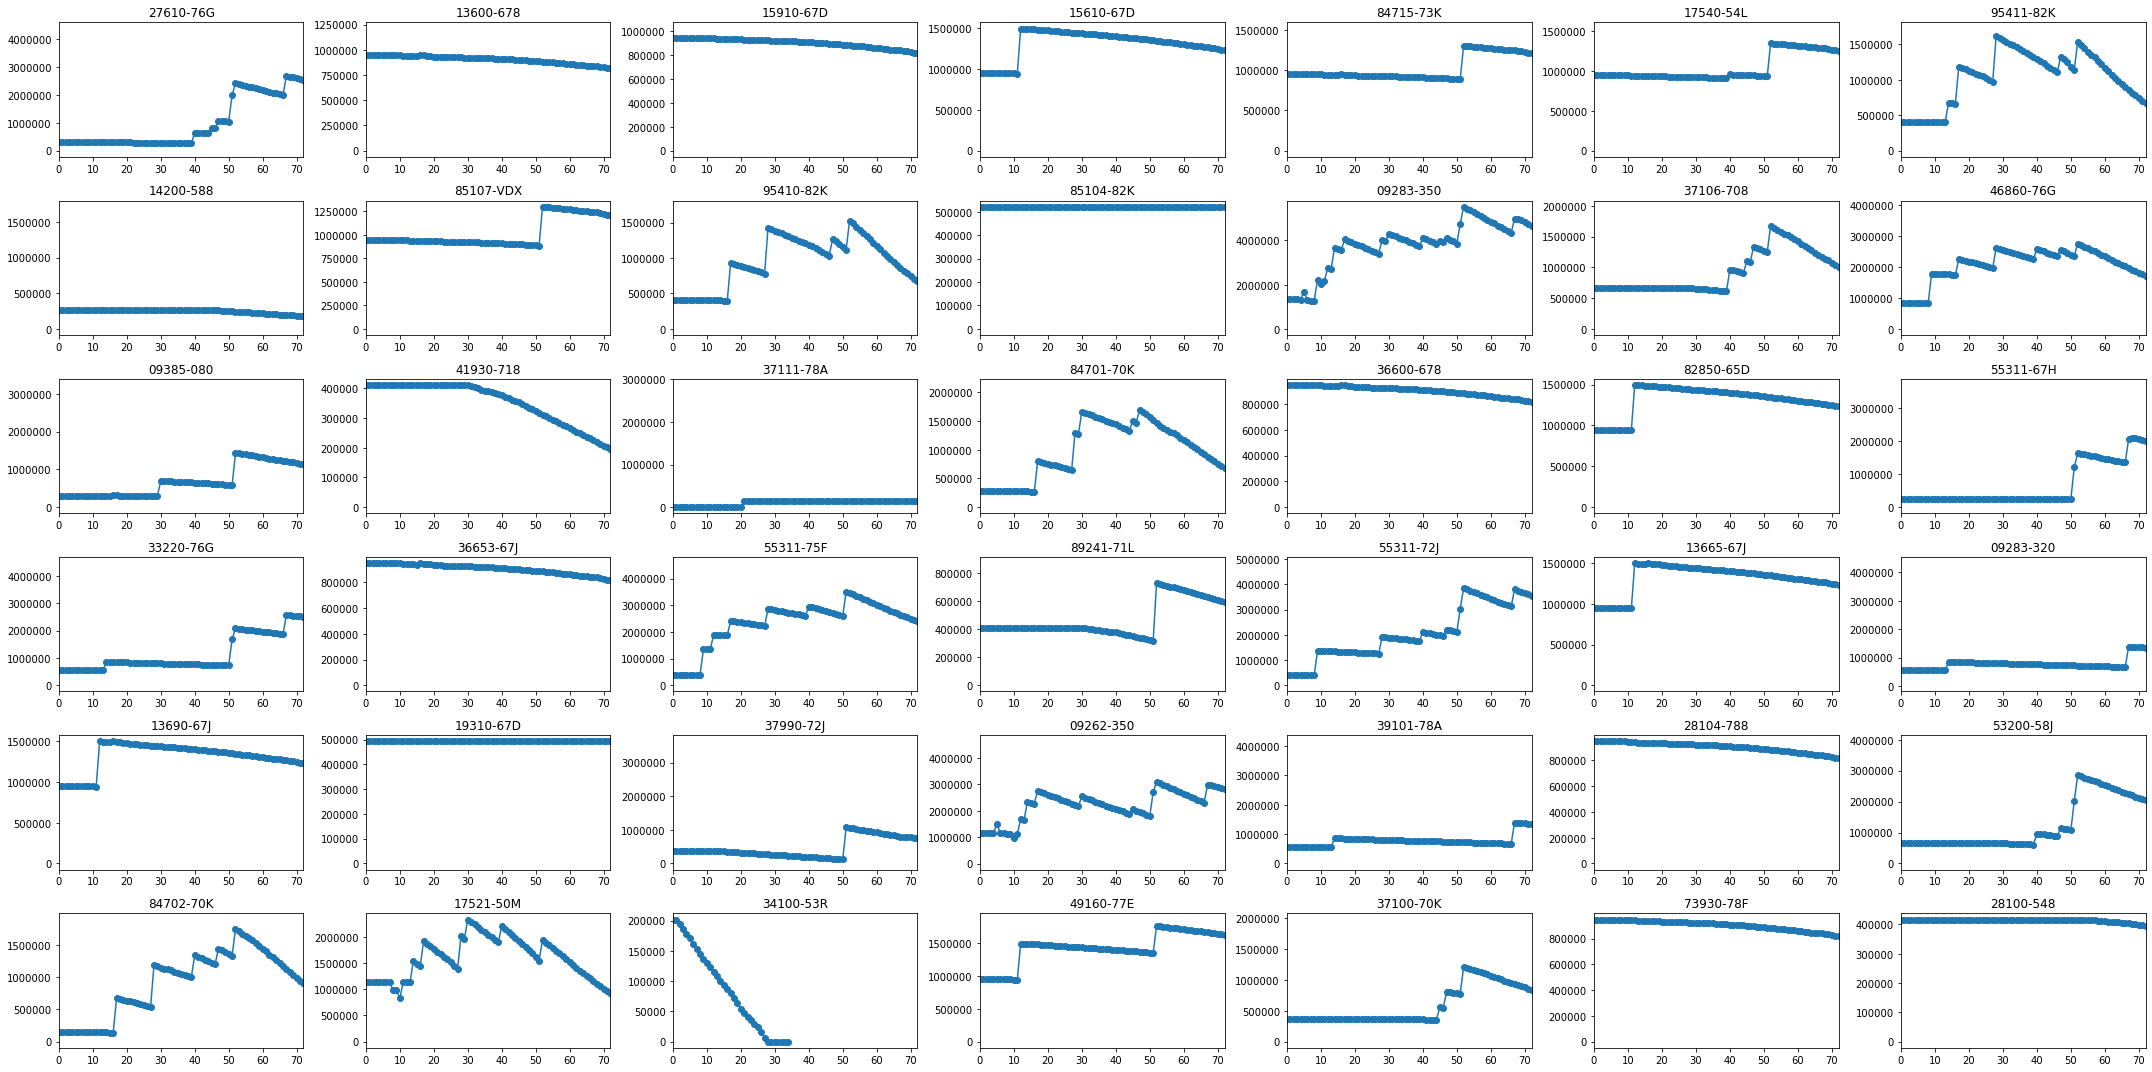

In [209]:
fig = plt.figure(figsize=(30,15))

for i, p in enumerate(parts_top.index[:42]):
    ax = fig.add_subplot(6, 7, i+1)
    model_having_parts = df_part_model_master[df_part_model_master.part_cd == p]
    tmp_total_running = (model_having_parts.merge(df_fcok_model_num_running_month_passed,
                                                 left_on="model_cd", right_on="PROD_CD", how="inner")
                         .groupby("MONTH")["running"]
                         .sum()
                         .to_frame(name="running")
                         .reset_index()
                         .rename(columns={"MONTH":"month"}))
    tmp_total_running = (dp.merge(tmp_total_running, on="month", how="left")
                         .fillna(method="bfill")
                         .set_index("month"))
    
    ax.plot(tmp_total_running.index, tmp_total_running.values, "o-")
    plt.title(p)
    ax.set_xlim(0, 72)
plt.tight_layout()
plt.show()

In [217]:
selected_col = ["27610-76G", "15610-67D", "95411-82K", 
                "85107-VDX", "09283-350", "37106-708",
                "46860-76G", "33220-76G", "55311-75F",
                "55311-72J", "37990-72J", "09262-350",
                "53200-58J", "84702-70K", "82850-65D"]

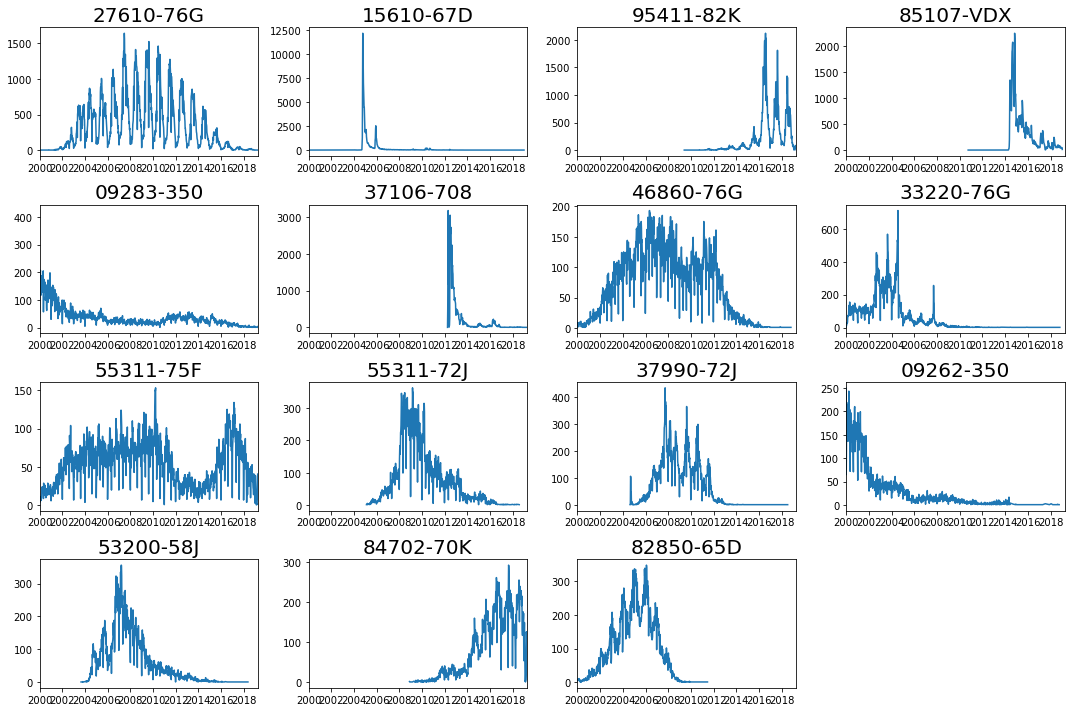

In [219]:
tmp = df_warranty_part_num_weekly.copy()
tmp = tmp.set_index("week")

plt.figure(figsize=(15,10))
for i, m in enumerate(selected_col):
    plt.subplot(4,4,i+1)
    val = tmp.loc[tmp.part_cd == m, "n"]
    plt.plot(val.index, val, "-")
    plt.title(m, fontsize=20)
    plt.xlim(datetime(2000,1,1),datetime(2019,4,1))
plt.tight_layout()
plt.show()